In [4]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from scipy import stats

import pandas_datareader.data as web

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML
sns.set_style('whitegrid')
data_path = Path('data')
fig_path = Path('figures')
model_path = Path('models')
for p in [data_path, fig_path, model_path]:
    if not p.exists():
        p.mkdir()

import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import arviz
import theano



You can find the C code in this temporary file: C:\Users\19498\AppData\Local\Temp\theano_compilation_error_db1c52n9


AttributeError: partially initialized module 'theano' has no attribute 'gof' (most likely due to a circular import)

In [5]:
#  source: https://fred.stlouisfed.org/
indicators = ['JHDUSRGDPBR', 'T10Y3M', 'NFCI', 'NFCINONFINLEVERAGE', 'UMCSENT']
var_names = ['recession', 'yield_curve', 'financial_conditions', 'leverage', 'sentiment']
features = var_names[1:]
label = var_names[0]
# leading indicator for Recession: Yield Curve, Financial Conditions, Leverage, Sentiment
var_display = ['Recession', 'Yield Curve', 'Financial Conditions', 'Leverage', 'Sentiment']
col_dict = dict(zip(var_names, var_display))
data = (web.DataReader(indicators, 'fred', 1980, 2023).ffill().resample('M').last().dropna())
data.columns = var_names
data.tail()

,recession,yield_curve,financial_conditions,leverage,sentiment
DATE,,,,,
2022-09-30,0.0,0.50,-0.11330,-0.93985,58.6
2022-10-31,0.0,-0.12,-0.14161,-0.89611,59.9
2022-11-30,0.0,-0.69,-0.20458,-0.86048,56.8
2022-12-31,0.0,-0.54,-0.25475,-0.82518,59.7
2023-01-31,0.0,-0.54,-0.25475,-0.82518,64.9


In [6]:
data.loc[:, features] = scale(data.loc[:, features])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 493 entries, 1982-01-31 to 2023-01-31
Freq: M
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             493 non-null    float64
 1   yield_curve           493 non-null    float64
 2   financial_conditions  493 non-null    float64
 3   leverage              493 non-null    float64
 4   sentiment             493 non-null    float64
dtypes: float64(5)
memory usage: 23.1 KB


In [7]:
data.tail()

,recession,yield_curve,financial_conditions,leverage,sentiment
DATE,,,,,
2022-09-30,0.0,-1.068749,0.253579,-0.878758,-2.259614
2022-10-31,0.0,-1.621684,0.209220,-0.837101,-2.155632
2022-11-30,0.0,-2.130027,0.110555,-0.803168,-2.403589
2022-12-31,0.0,-1.996252,0.031945,-0.769549,-2.171629
2023-01-31,0.0,-1.996252,0.031945,-0.769549,-1.755702


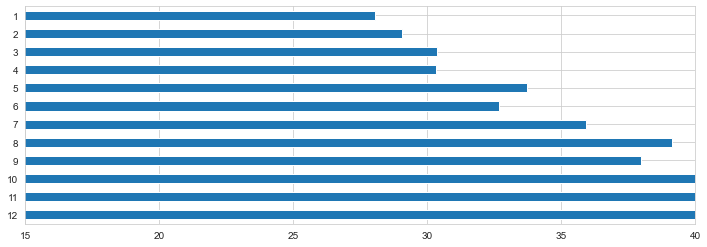

In [8]:
mi = []
months = list(range(1, 25))
for month in months:
    df_ = data.copy()
    df_[label] = df_[label].shift(-month)
    df_ = df_.dropna()
    # mutual_info_classif: Estimate mutual information for a discrete target variable
    mi.append(mutual_info_classif(df_.loc[:, features], df_[label]))
mi = pd.DataFrame(mi, columns=features, index=months)
mi.sum(1).mul(100).iloc[:12].sort_index(ascending=False).plot.barh(figsize=(12, 4), xlim=(15, 40));

In [10]:
mi.tail()

,yield_curve,financial_conditions,leverage,sentiment
20,0.101563,0.087277,0.176023,0.033907
21,0.097630,0.088616,0.176622,0.041785
22,0.101789,0.075761,0.158315,0.041714
23,0.065952,0.073918,0.127289,0.041221
24,0.036196,0.065641,0.111892,0.024398


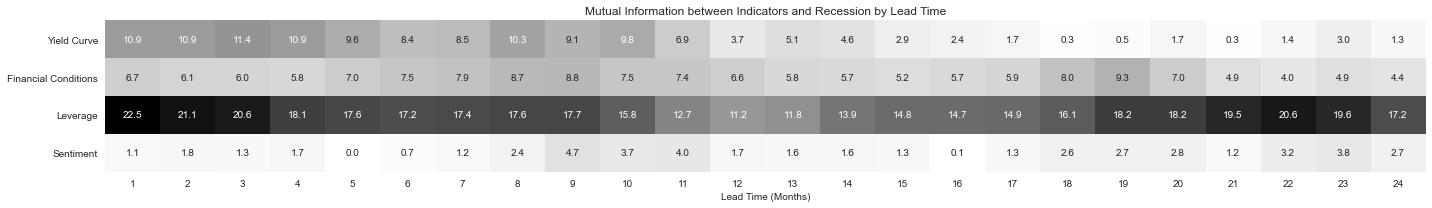

In [9]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(mi.rename(columns=col_dict).T*100, cmap='Greys', ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Lead Time (Months)')
ax.set_title('Mutual Information between Indicators and Recession by Lead Time')
fig.tight_layout()

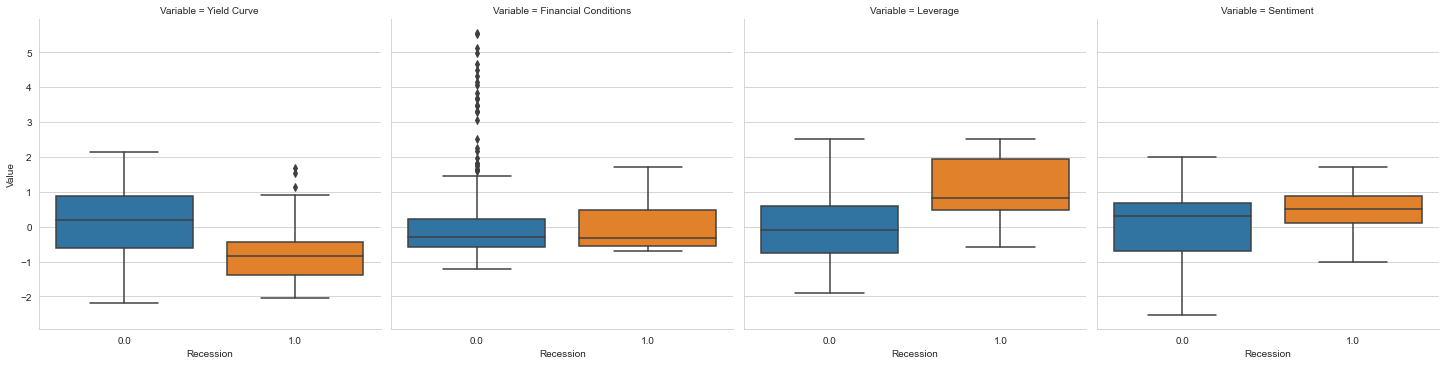

In [12]:
data[label] = data[label].shift(-12)
data = data.dropna()
data_ = pd.melt(data.rename(columns=col_dict), id_vars='Recession').rename(columns=str.capitalize)
g = sns.catplot(x='Recession', y='Value', col='Variable', data=data_, kind='box');

In [19]:
X = data.loc[:, features]
y = data[label]
y.value_counts()

0.0    427
1.0     54
Name: recession, dtype: int64

In [20]:
data.to_csv('data/recessions.csv')

In [21]:
data = pd.read_csv('data/recessions.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 481 entries, 1982-01-31 to 2022-01-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             481 non-null    float64
 1   yield_curve           481 non-null    float64
 2   financial_conditions  481 non-null    float64
 3   leverage              481 non-null    float64
 4   sentiment             481 non-null    float64
dtypes: float64(5)
memory usage: 22.5+ KB


In [22]:
simple_model = 'recession ~ yield_curve + leverage'
full_model =  simple_model + ' + financial_conditions + sentiment'

In [28]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with
    # uninformative priors for each parameter

    intercept = pm.Normal('intercept', 0, sd=100)
    beta_1 = pm.Normal('beta_1', 0, sd=100)
    beta_2 = pm.Normal('beta_2', 0, sd=100)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept +
                             beta_1 * data.yield_curve +
                             beta_2 * data.leverage)

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit',
                 p=likelihood,
                 observed=data.recession)
manual_logistic_model.model

NameError: name 'pm' is not defined

In [24]:
pm.model_to_graphviz(manual_logistic_model)

NameError: name 'pm' is not defined

In [ ]:
# opionally: persist
# graph = pm.model_to_graphviz(manual_logistic_model)
# graph.save('log_reg.dot')

with manual_logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})
print_map(manual_map_estimate)

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(simple_model,
                            data,
                            family=pm.glm.families.Binomial())
pm.model_to_graphviz(logistic_model)

In [ ]:
with logistic_model:
    map_estimate = pm.find_MAP()

In [ ]:
model = smf.logit(formula=simple_model, data=data)
result = model.fit()
print(result.summary())

In [ ]:
print_map(map_estimate)

In [ ]:
result.params

In [ ]:
def plot_traces(traces, burnin=2000):
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', xy=(mn, 0),
                          xycoords='data', xytext=(5, 10),
                          textcoords='offset points',
                          rotation=90, va='bottom',
                          fontsize='large',
                          color='#AA0022')

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())
logistic_model.basic_RVs

In [ ]:
with logistic_model:
    trace_mh = pm.sample(tune=1000,
                         draws=5000,
                         step=pm.Metropolis(),
                         cores=4)

In [ ]:
plot_traces(trace_mh, burnin=0)

In [ ]:
pm.trace_to_dataframe(trace_mh).info()

In [ ]:
# Continue Training
with logistic_model:
    trace_mh = pm.sample(draws=100000,
                         step=pm.Metropolis(),
                         trace=trace_mh)

In [ ]:
plot_traces(trace_mh, burnin=0)

In [ ]:
# optionally: persist
# with open('logistic_model_mh.pkl', 'wb') as buff:
#     pickle.dump({'model': logistic_model, 'trace': trace_mh}, buff)
# optionally: restore persisted model
# with open('logistic_model_mh.pkl', 'rb') as buff:
#     pickled_data = pickle.load(buff)

# logistic_model, trace_mh = pickled_data['model'], pickled_data['trace']
arviz.summary(trace_mh)

In [ ]:
draws = 100
tune = 1000
with logistic_model:
    trace_NUTS = pm.sample(draws=draws,
                           tune=tune,
                           init='adapt_diag',
                           chains=4,
                           cores=1,
                           random_seed=42)

In [ ]:
trace_df = pm.trace_to_dataframe(trace_NUTS).assign(
    chain=lambda x: x.index // draws)
trace_df.info()

In [ ]:
plot_traces(trace_NUTS, burnin=0)

In [ ]:
draws = 50000
chains = 4
with logistic_model:
    trace_NUTS = pm.sample(draws=draws,
                           tune=tune,
                           init='adapt_diag',
                           trace=trace_NUTS,
                           chains=chains,
                           cores=1,
                           random_seed=42)

In [ ]:
plot_traces(trace_NUTS, burnin=1000)

In [ ]:
# Persist Results
# optional
# with open('logistic_model_nuts.pkl', 'wb') as buff:
#     pickle.dump({'model': logistic_model,
#                  'trace': trace_NUTS}, buff)
# with open('logistic_model_nuts.pkl', 'rb') as buff:
#     pickled_data = pickle.load(buff)

# logistic_model, trace_NUTS = pickled_data['model'], pickled_data['trace']

In [ ]:
# Combine Traces
df = pm.trace_to_dataframe(trace_NUTS).iloc[200:].reset_index(
    drop=True).assign(chain=lambda x: x.index // draws)
trace_df = pd.concat([trace_df.assign(samples=100),
                      df.assign(samples=len(df) + len(trace_df))])
trace_df.info()

In [ ]:
# Visualize both traces
trace_df_long = pd.melt(trace_df, id_vars=['samples', 'chain'])
trace_df_long.info()

In [ ]:
g = sns.FacetGrid(trace_df_long, col='variable', row='samples', hue='chain', sharex='col', sharey=False)
g = g.map(sns.distplot, 'value', hist=False, rug=False);

In [ ]:
model = smf.logit(formula=full_model, data=data)
result = model.fit()
print(result.summary())

In [ ]:
arviz.summary(trace_NUTS).assign(statsmodels=result.params).to_csv(model_path / 'trace_nuts.csv')
arviz.summary(trace_NUTS).assign(statsmodels=result.params)

In [ ]:
# Computing Credible Intervals

def get_credible_int(trace, param):
    b = trace[param]
    lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
    lb, ub = np.exp(lb), np.exp(ub)
    return b, lb, ub
b = trace_NUTS['yield_curve']
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
lb, ub = np.exp(lb), np.exp(ub)
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

In [ ]:
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

In [ ]:

fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[0])
axes[0].set_title(f'Yield Curve: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[0].axvspan(lb, ub, alpha=0.5, color='gray')

b, lb, ub = get_credible_int(trace_NUTS, 'leverage')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[1])
axes[1].set_title(f'Leverage: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[1].axvspan(lb, ub, alpha=0.5, color='gray')

fig.suptitle('Credible Intervals', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

In [ ]:
with logistic_model:
    callback = CheckParametersConvergence(diff='absolute')
    approx = pm.fit(n=100000,
                    callbacks=[callback])

In [ ]:
# Persist Result
# optional
# with open(logistic_model_advi.pkl', 'wb') as buff:
#     pickle.dump({'model': logistic_model,
#                  'approx': approx}, buff)

In [ ]:
trace_advi = approx.sample(10000)
arviz.summary(trace_advi)

In [ ]:
arviz.summary(trace_advi).to_csv(model_path / 'trace_advi.csv')

In [ ]:
# Energy Plot
arviz.plot_energy(trace_NUTS);

In [ ]:
# Forest Plot
arviz.plot_forest(trace_NUTS);

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
arviz.plot_forest(trace_NUTS, ax=axes[0])
axes[0].set_title('Forest Plot')

arviz.plot_energy(trace_NUTS, ax=axes[1])
axes[1].set_title('Energy Plot')

fig.tight_layout();

In [ ]:
# Posterior Predictive Checks
ppc = pm.sample_posterior_predictive(trace_NUTS, samples=500, model=logistic_model)

In [ ]:
ppc['y'].shape

In [ ]:
y_score = np.mean(ppc['y'], axis=0)
roc_auc_score(y_score=np.mean(ppc['y'], axis=0),
              y_true=data.recession)

In [ ]:
# Prediction

X = data[['yield_curve']]
labels = X.columns
y = data.recession
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_shared = theano.shared(X_train.values)

with pm.Model() as logistic_model_pred:
    pm.glm.GLM(x=X_shared, labels=labels, y=y_train, family=pm.glm.families.Binomial())


with logistic_model_pred:
    pred_trace = pm.sample(draws=10000, tune=1000, chains=2, cores=1, init='adapt_diag')


X_shared.set_value(X_test)
ppc = pm.sample_posterior_predictive(pred_trace, model=logistic_model_pred, samples=100)

In [ ]:
# Check AUC Score
y_score = np.mean(ppc['y'], axis=0)
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), y_true=y_test)

In [ ]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))
x = X_test.yield_curve

fig, ax = plt.subplots(figsize=(14, 5))

β = stats.beta((ppc['y'] == 1).sum(axis=0), (ppc['y'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=x, y=β.mean())

# error bars on the estimate
plt.vlines(x, *β.interval(0.95))

# actual outcomes
ax.scatter(x=x, y=y_test, marker='x')

# True probabilities
x_ = np.linspace(x.min()*1.05, x.max()*1.05, num=100)
ax.plot(-x_, invlogit(x_), linestyle='-')

ax.set_xlabel('Yield Curve')
ax.set_ylabel('Recession')
ax.invert_xaxis()
fig.tight_layout()

In [ ]:
# MCMC Sampler Animation
# setup

# Number of MCMC iteration to animate.
burnin = 1000
samples = 1000

var1 = 'yield_curve'
var1_range = (trace_df[var1].min() * .95, trace_df[var1].max() * 1.05)

var2 = 'sentiment'
var2_range = (trace_df[var2].min() * .95, trace_df[var2].max() * 1.05)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

In [ ]:
# NUTS samples
def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines
with logistic_model:
    nuts_trace = pm.sample(draws=samples, tune=burnin,
                      init='adapt_diag',
                      chains=1)
    trace_df = pm.trace_to_dataframe(nuts_trace)
trace_df.to_csv('trace.csv', index=False)
trace_df = pd.read_csv('trace.csv')
print(trace_df.info())

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]


anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True);

# save
# anim.save('nuts.mp4', writer=writer)
# or display; either requres ffmpeg installation
HTML(anim.to_html5_video())

In [ ]:
# Metropolis-Hastings samples
with logistic_model:
    step = pm.Metropolis()
    mh_trace = pm.sample(draws=samples, tune=burnin,
                      step=step,
                      chains=1)
    trace_df = pm.trace_to_dataframe(mh_trace)

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True)

HTML(anim.to_html5_video())